In [1]:
import numpy as np
import matplotlib.pyplot as plt

def stimulus_velocity(drift_speed,swim_power,motosensory_gain):

  # Fictive environment stimulus velcity calculation from Mu et al, 2019.

  return drift_speed - motosensory_gain * swim_power



def mismatch(stim_velocity,swim_power):

  # overshooting (i.e., negative stim velocity) should lead to zero mismatch

  return np.maximum(0,stim_velocity)*swim_power


def generate_periodic_hump_function(duration_ms, step_interval_ms=1000, step_duration_ms=500, timestep_ms=1):
    """
    Generates a periodic hump function using the top half of a sine wave.

    Parameters:
    duration_ms (int): Total duration of the signal in milliseconds.
    step_interval_ms (int): Time interval between the start of each hump in milliseconds. Default is 1000ms (1 second).
    step_duration_ms (int): Duration of each hump in milliseconds. Default is 250ms.
    timestep_ms (int): Time resolution of the signal in milliseconds. Default is 1ms.

    Returns:
    np.ndarray: Array representing the periodic hump function.
    """

    # Calculate the total number of time steps
    num_timesteps = duration_ms // timestep_ms

    # Initialize the signal array with zeros (inactive state)
    signal = np.zeros(num_timesteps)

    # Generate the top half of a sine wave for the hump
    hump_timesteps = step_duration_ms // timestep_ms
    t = np.linspace(0, np.pi, hump_timesteps)  # linspace to create a smooth hump over the specified duration
    hump = (np.sin(t) + 1) / 2  # normalize the sine wave to be between 0 and 1

    # Set the humps in the signal
    for start_time in range(0, duration_ms, step_interval_ms):
        start_index = start_time // timestep_ms
        end_index = start_index + hump_timesteps
        signal[start_index:end_index] = hump

    return signal



In [2]:
def run_sim(sim_params, agent_params):
    # Extract simulation parameters
    duration = sim_params['duration']
    drift_speed = sim_params['drift_speed']
    motosensory_gain = sim_params['motosensory_gain']
    open_loop_start_time, open_loop_end_time = sim_params['open_loop_start_and_end_time']

    # Time array (1ms timestep)
    times = np.arange(0, duration, 1)

    # Generate fish swimming pattern
    swim_powers = generate_periodic_hump_function(duration)

    # Initialize arrays for stimulus velocity, mismatch error, futility integrator, and shut down circuit
    vs = np.zeros(len(times))
    es = np.zeros(len(times))
    fs = np.zeros(len(times))
    f_integrator = np.zeros(len(times))
    gs = np.zeros(len(times))
    
    # Extract agent parameters
    f_integration_tau = agent_params['f_integration_tau']
    f_integration_decay_constant = agent_params['f_integration_decay_constant']
    f_integration_gain = agent_params['f_integration_gain']
    f_threshold = agent_params['f_threshold']
    gaba_gain = agent_params['gaba_gain']
    gaba_threshold = agent_params['gaba_threshold']

    # Main simulation loop
    for t in times:
        if open_loop_start_time < t < open_loop_end_time:
            # Switch into open loop
            motosensory_gain = 0
        else:
          motosensory_gain = sim_params['motosensory_gain']

        if gs[t - 1] > gaba_threshold:
            # If futility integrator exceeds threshold, stop swimming
            swim_powers[t] = 0

        # Compute stimulus velocity and mismatch error
        vs[t] = stimulus_velocity(drift_speed, swim_powers[t], motosensory_gain)
        es[t] = mismatch(vs[t], swim_powers[t])

        # Update futility integrator and gaba circuit
        f_integrator[t] = f_integrator[t - 1] + (1 / f_integration_tau) * (
            -f_integration_decay_constant * f_integrator[t - 1] + f_integration_gain * es[t])
        gs[t] = gs[t - 1] + (1 / f_integration_tau) * (
            -f_integration_decay_constant * gs[t - 1] + gaba_gain * max(0, f_integrator[t] - f_threshold))

    # Collect results in a dictionary
    result_dict = {
        'swim_powers': swim_powers,
        'vs': vs,
        'es': es,
        'f_integrator': f_integrator,
        'gs': gs
    }

    return result_dict




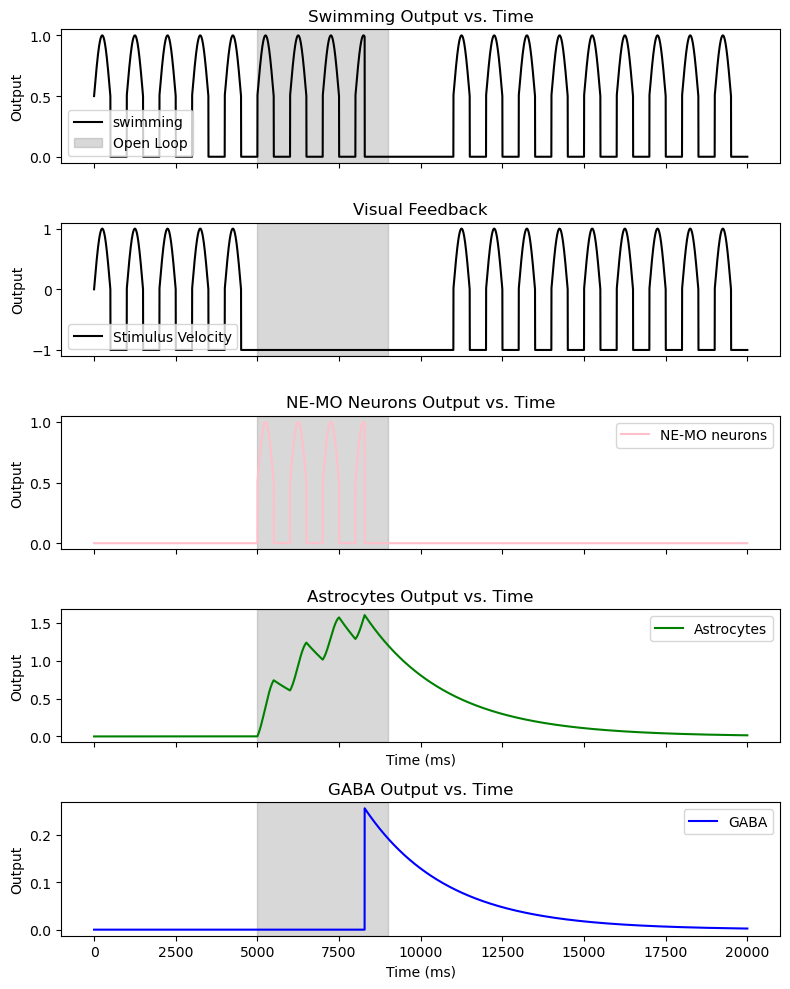

In [ ]:

# Simulation parameters
sim_params = {
    'duration': 20000,  # Duration of the whole simulation in ms
    'open_loop_start_and_end_time': [5000 - 1, 9000],  # Open loop start and end times
    'drift_speed': 1,  # Striped bar drift speed
    'motosensory_gain': 2  # Gain from agent swimming power to stripes
}

# Agent parameters
agent_params = {
    'f_integration_tau': 5000,
    'f_integration_decay_constant': 2,
    'f_integration_gain': 10,
    'f_threshold': 1.6,  # Astrocyte activity threshold for giving up
    'gaba_gain':int(1e6),
    'gaba_threshold': 0.1
}


# Run the simulation
results = run_sim(sim_params, agent_params)


# Extract the open loop times
open_loop_start_time, open_loop_end_time = sim_params['open_loop_start_and_end_time']

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

# Plot swim_powers in the first subplot
axs[0].plot(results['swim_powers'], label='swimming', color='k')
axs[0].set_ylabel('Output')
axs[0].set_title('Swimming Output vs. Time')
axs[0].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3,label = 'Open Loop')  # Shade area
axs[0].legend()

# Plot vs in the second subplot
axs[1].plot(-results['vs'], label='Stimulus Velocity', color='k')
axs[1].set_ylabel('Output')
axs[1].set_title('Visual Feedback')
axs[1].legend()
axs[1].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)  # Shade area

# Plot es in the third subplot
axs[2].plot(results['es'], label='NE-MO neurons', color='pink')
axs[2].set_ylabel('Output')
axs[2].set_title('NE-MO Neurons Output vs. Time')
axs[2].legend()
axs[2].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)  # Shade area

# Plot f_integrator in the fourth subplot
axs[3].plot(results['f_integrator'], label='Astrocytes', color='g')
axs[3].set_xlabel('Time (ms)')
axs[3].set_ylabel('Output')
axs[3].set_title('Astrocytes Output vs. Time')
axs[3].legend()
axs[3].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)  # Shade area

# Plot gs in the fifth subplot
axs[4].plot(results['gs'], label='GABA', color='b')
axs[4].set_xlabel('Time (ms)')
axs[4].set_ylabel('Output')
axs[4].set_title('GABA Output vs. Time')
axs[4].legend()
axs[4].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)  # Shade area

# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plot
plt.show()

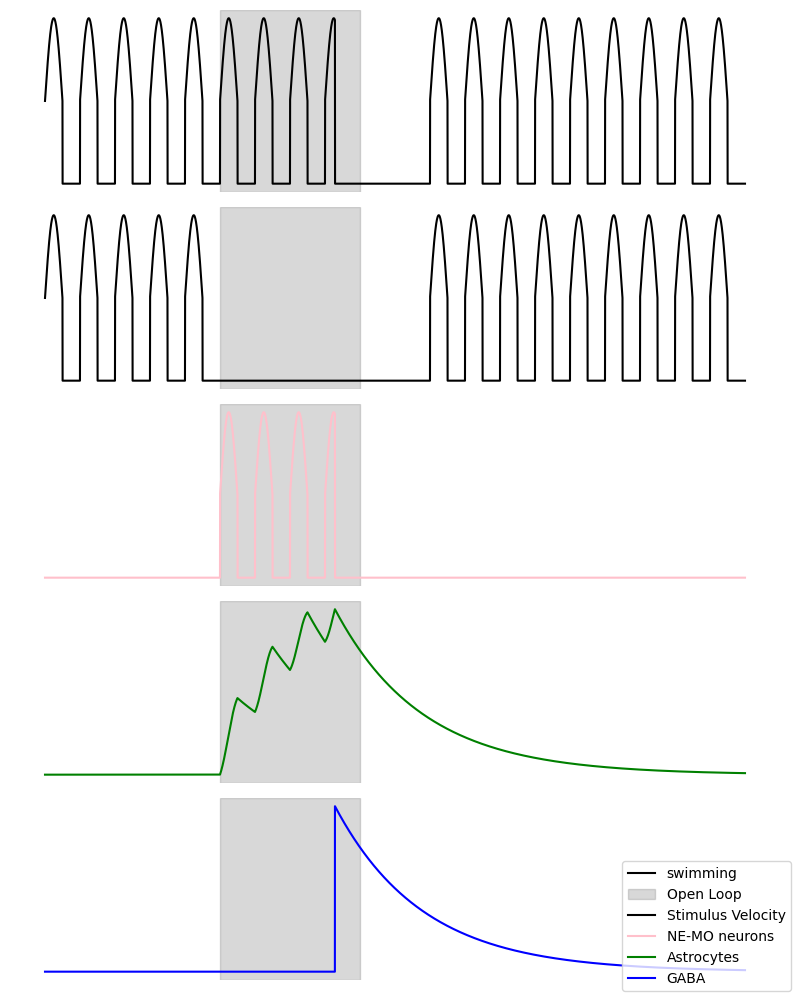

In [11]:
import matplotlib.pyplot as plt

# Create subplots with the same layout
fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True)

# Plot swim_powers in the first subplot
line0 = axs[0].plot(results['swim_powers'], label='swimming', color='k')
axs[0].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3, label='Open Loop')

# Plot vs in the second subplot (negative as in your code)
line1 = axs[1].plot(-results['vs'], label='Stimulus Velocity', color='k')
axs[1].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)

# Plot es in the third subplot
line2 = axs[2].plot(results['es'], label='NE-MO neurons', color='pink')
axs[2].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)

# Plot f_integrator in the fourth subplot
line3 = axs[3].plot(results['f_integrator'], label='Astrocytes', color='g')
axs[3].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)

# Plot gs in the fifth subplot
line4 = axs[4].plot(results['gs'], label='GABA', color='b')
axs[4].axvspan(open_loop_start_time, open_loop_end_time, color='gray', alpha=0.3)

# Remove titles, labels, ticks, and spines for a "seamless" stacked look
for ax in axs:
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Collect all lines/labels from each subplot for a single figure-level legend
handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Build one legend at the top-right (adjust loc as you like)
fig.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.show()